In [286]:
import networkx as nx
import matplotlib.pyplot as plt

### GRAPH CREATION

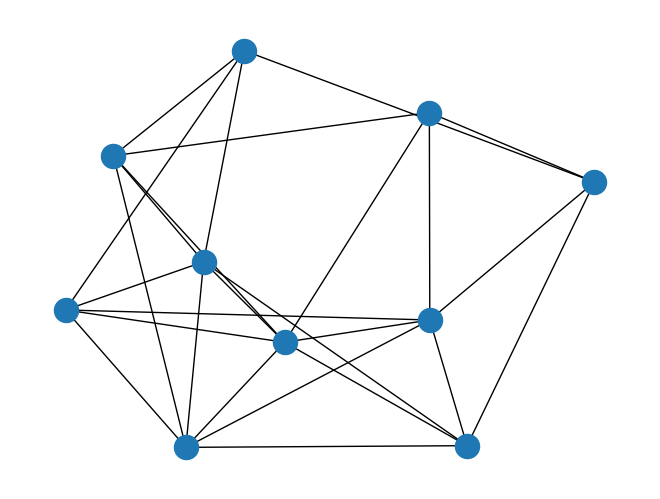

In [325]:
G = nx.erdos_renyi_graph(10, 0.6)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
nx.draw(G)
plt.show()

In [326]:
import itertools
import random

def find_all_node_cuts_of_size(graph, cut_size, num_samples):
    node_cuts = []
    nodes = list(graph.nodes())
    num_nodes = len(nodes)
    
    for _ in range(num_samples):
        # Randomly sample a subset of nodes of size 'cut_size'
        nodes_subset = random.sample(nodes, cut_size)
        
        # Create a copy of the graph
        graph_copy = graph.copy()
        
        # Remove the subset of nodes
        graph_copy.remove_nodes_from(nodes_subset)
        
        # Check if the graph is disconnected
        if nx.number_connected_components(graph_copy) == 2:
            # If disconnected, add the subset of nodes to the list
            node_cuts.append(nodes_subset)
    
    return node_cuts

### BALANCED-LOW-CARDINALITY VERTEX SEPARATOR

In [327]:
def get_balanced_separator(G, card_diff, rannum = 1000):
    for k in range(nx.node_connectivity(G), G.number_of_nodes()):
        for cut in find_all_node_cuts_of_size(G, k, rannum):
            graph_copy = G.copy()
            for node in cut:
                graph_copy.remove_node(node)
            subgraph1 = list(nx.connected_components(graph_copy))[0]
            subgraph2 = list(nx.connected_components(graph_copy))[1]
            if abs(len(subgraph1) - len(subgraph2)) <= card_diff:
                return cut
    return None

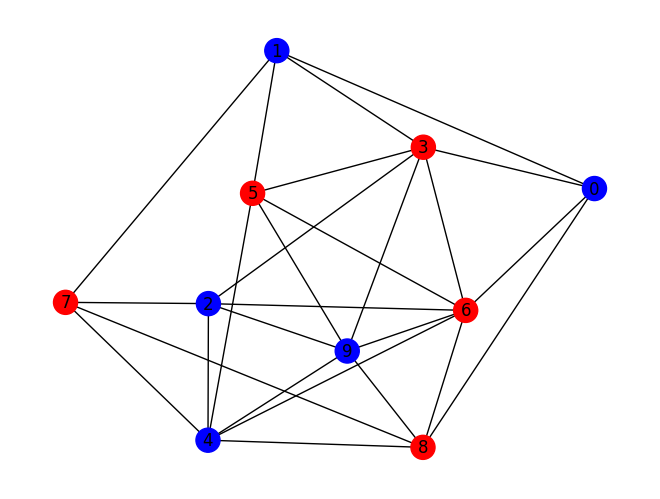

In [328]:
cut = get_balanced_separator(G, 1)
lst = {}
for node in list(G.nodes()):
    if node in cut:
        lst[node] = 'red'
    else:
        lst[node] = 'blue'
        
nx.set_node_attributes(G, lst, name = 'color')
# Set color for each node
node_colors = []
for node in G.nodes():
    node_colors.append(G.nodes[node]['color'])

# Draw the graph with specified node colors
nx.draw(G, with_labels=True, node_color=node_colors)

plt.show()

In [329]:
import cvxpy as cp
import scipy as sp
n_nodes = G.number_of_nodes()
X = cp.Variable((n_nodes, n_nodes), symmetric = True)
constraints = [X >> 0]
constraints += [X[i,i] == 1 for i in range(n_nodes)]
objective = sum(0.5 * G[i][j]['weight'] * (1 - X[i, j]) for (i, j) in G.edges())
prob = cp.Problem(cp.Maximize(objective), constraints)

prob.solve()

xs = sp.linalg.sqrtm(X.value)
plane = np.random.randn(n_nodes)
xs = np.real(np.sign(xs @ plane))
xs

array([-1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.])

### GRAPH-SHRINKING

In [330]:
import numpy as np

def find_max(matrix):
    max_value = matrix[0][0]
    max_index = (0, 0)
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value > max_value:
                max_value = value
                max_index = (i, j)
    return max_index
    
def shrink_step(graph, node1, node2):
    edges1 = graph.edges(node1, data = True)
    edges2 = graph.edges(node2, data = True)
    neighbors1 = [edge[1] for edge in edges1]
    neighbors2 = [edge[1] for edge in edges2]
    weights1 = [edge[2] for edge in edges1]
    weights2 = [edge[2] for edge in edges2]
    sigma = xs[node1] * xs[node2]
    graph.remove_node(node1)

    for i, neighbor in enumerate(neighbors1):
        weight1 = weights1[i]['weight']

        if neighbor in neighbors2:
            weight2 = weights2[neighbors2.index(neighbor)]['weight']
            weight = sigma * weight1 + weight2
            graph.remove_edge(node2 , neighbor)
            graph.add_edge(node2 , neighbor, weight = weight)
        else:
            weight = sigma * weight1
            graph.add_edge(list(graph.nodes()).index(neighbor) , list(graph.nodes()).index(node2), weight = weight)
    graph = nx.convert_node_labels_to_integers(graph)

    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph


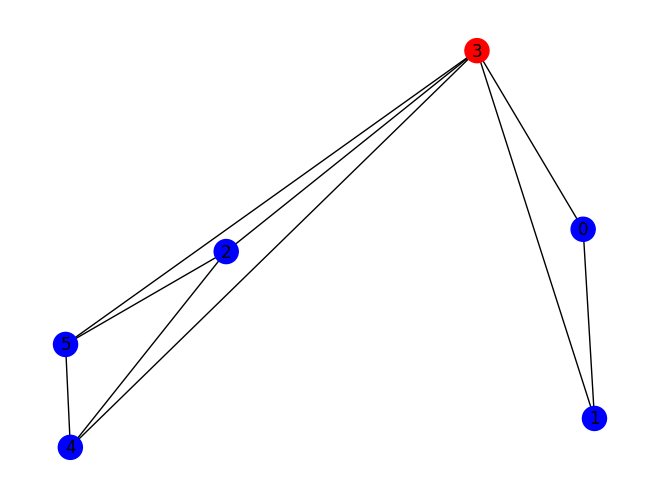

{0: 'blue', 1: 'blue', 2: 'blue', 3: 'red', 4: 'blue', 5: 'blue'}

In [334]:
G = shrink_step(G, 5, 3)
node_colors = []
for node in G.nodes:
    node_colors.append(G.nodes[node]['color'])
nx.draw(G, with_labels = True, node_color=node_colors)
plt.show()
nx.get_node_attributes(G, 'color')